<a href="https://colab.research.google.com/github/PAVANKANTH96/Data-Science-For-Beginners/blob/main/Sentimental%20Analysis%20of%20Yelp%20reviews%20using%20RNN%2C%20CNN%20and%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from datetime import datetime

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Project_3_Dataset/train.csv', names=('class', 'text'))
test_data = pd.read_csv('/content/drive/MyDrive/Project_3_Dataset/test.csv', names=('class', 'text'))
X_train = train_data['text']
y_train = train_data['class']
X_test = test_data['text']
y_test = test_data['class']

In [5]:
train_data

,class,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [6]:
train_data.loc[train_data["class"] == 1, "class"] = 0
train_data.loc[train_data["class"] == 2, "class"] = 1
test_data.loc[test_data["class"] == 1, "class"] = 0
test_data.loc[test_data["class"] == 2, "class"] = 1

<Axes: >

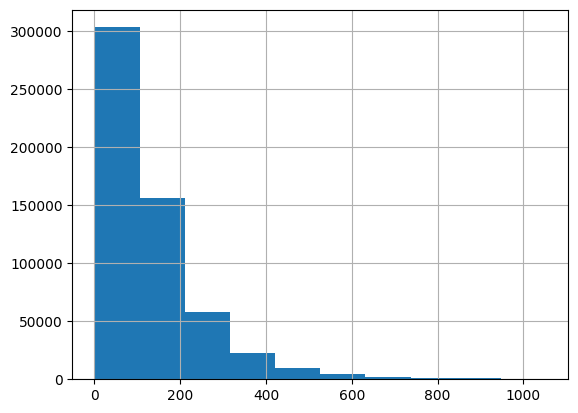

In [7]:
train_data["word_count"] = train_data["text"].str.split().str.len()
train_data["word_count"].hist()

In [8]:
X_train = train_data['text']
y_train = train_data['class']
X_test = test_data['text']
y_test = test_data['class']

In [9]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
max_length = 300
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=max_length)

# **RNN MODEL**

In [43]:
embedding_dim = 32
lstm_units_1 = 64
lstm_units_2 = 16
dense_units = 64
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units_1, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units_2)),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [44]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [45]:
loss_function = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
num_epochs = 3
validation_split = 0.3
batch_size = 200
model_rnn.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
history_rnn = model_rnn.fit(X_train, y_train, epochs=num_epochs, validation_split=validation_split, batch_size=batch_size, shuffle=True, callbacks=[early_stop])

Epoch 1/3
1960/1960 [==============================] - 172s 85ms/step - loss: 0.5165 - accuracy: 0.7782 - val_loss: 0.2906 - val_accuracy: 0.9217
Epoch 2/3
1960/1960 [==============================] - 102s 52ms/step - loss: 0.4570 - accuracy: 0.8264 - val_loss: 0.3015 - val_accuracy: 0.8994
Epoch 3/3
1960/1960 [==============================] - 97s 50ms/step - loss: 0.4487 - accuracy: 0.8392 - val_loss: 0.3952 - val_accuracy: 0.8290


In [46]:
import os
models_dir = '/content/drive/MyDrive/'
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, 'rnn_model.h5')
model_rnn.save(model_path)

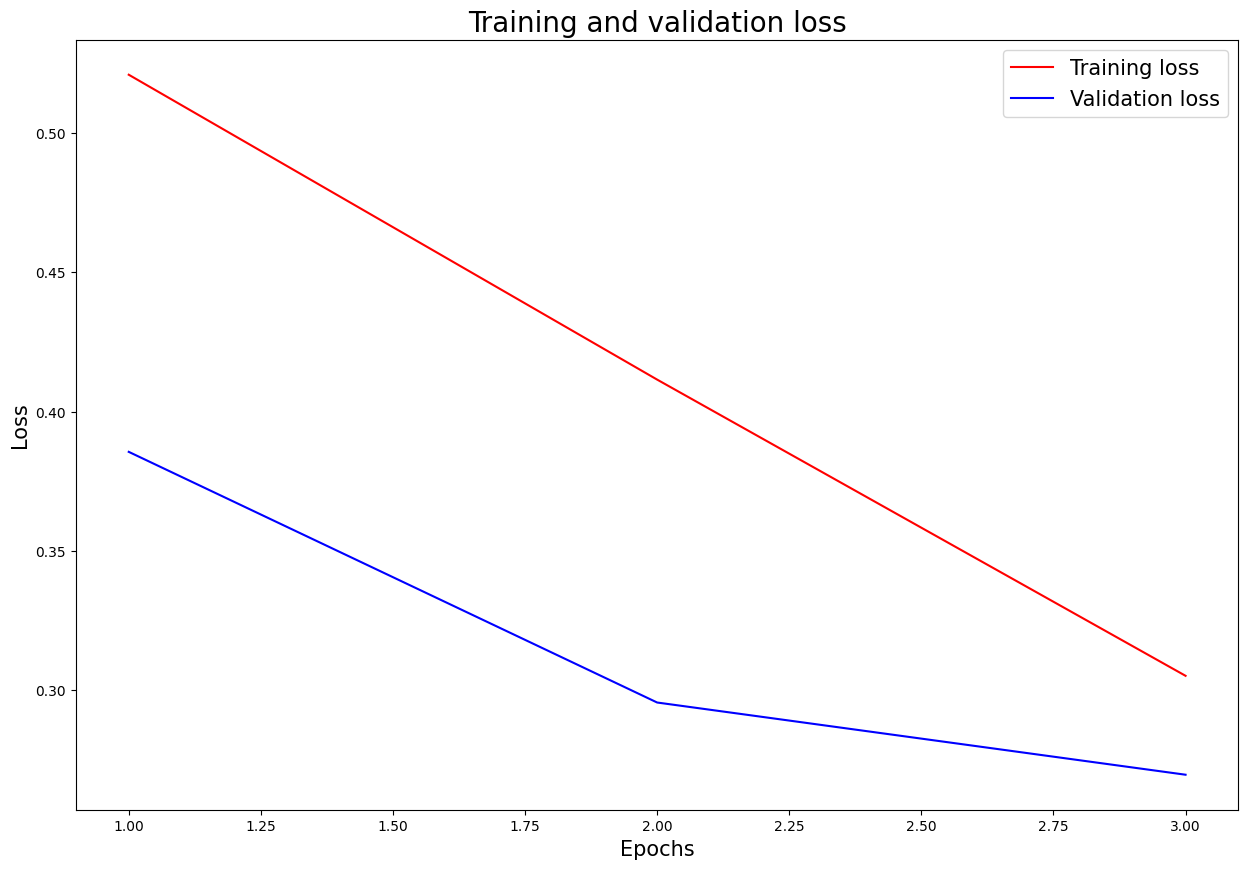

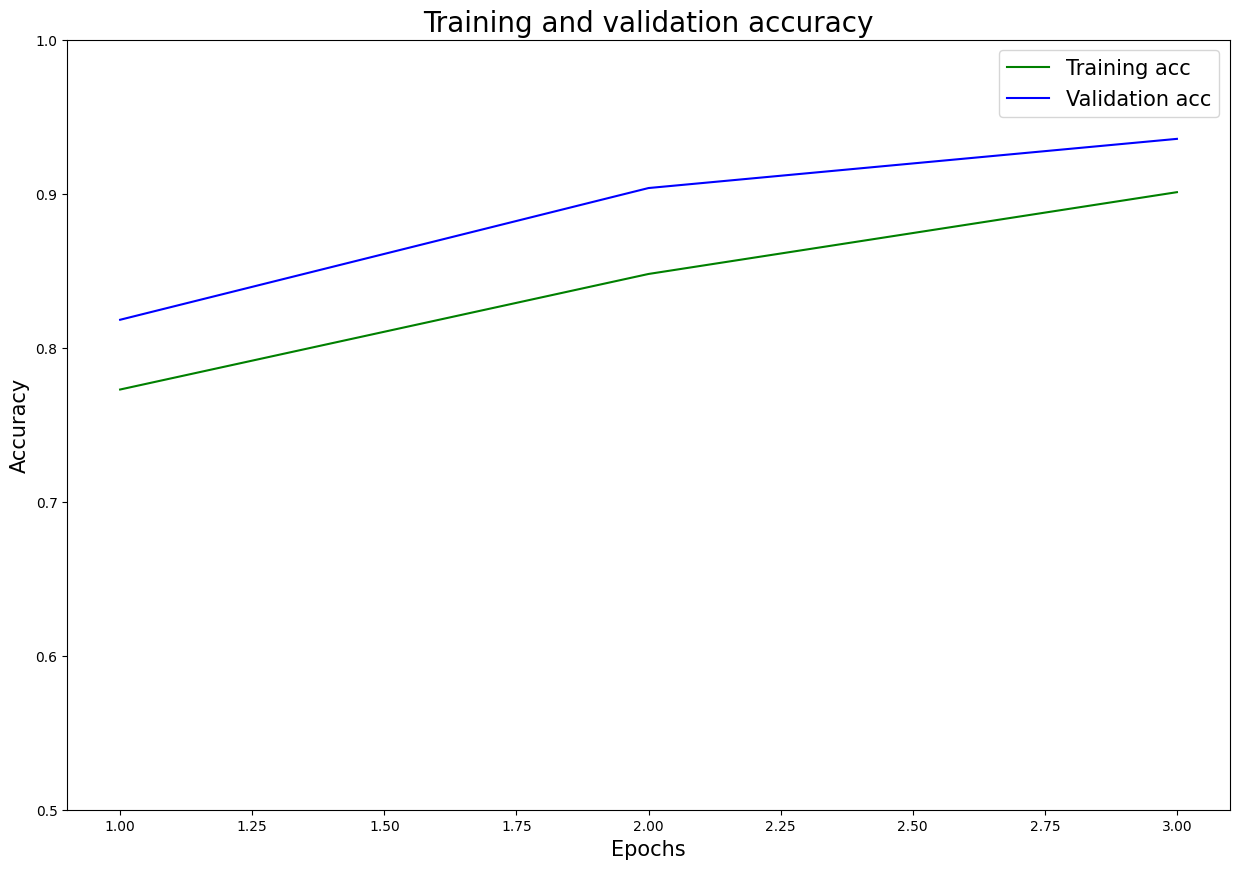

In [16]:
history_rnn_dict = history_rnn.history
acc_rnn = history_rnn_dict['accuracy']
val_acc_rnn = history_rnn_dict['val_accuracy']
loss_rnn = history_rnn_dict['loss']
val_loss_rnn = history_rnn_dict['val_loss']
epochs_rnn = range(1, num_epochs+1)

plt.figure(figsize=(15,10))
plt.plot(epochs_rnn, loss_rnn, 'r', label='Training loss')
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs_rnn, acc_rnn, 'g', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

# Model Evaluation

In [17]:
model_rnn.evaluate(X_test, y_test)

1188/1188 [==============================] - 18s 15ms/step - loss: 0.2586 - accuracy: 0.9340


[0.25856611132621765, 0.9339736700057983]

In [18]:
pred_rnn = model_rnn.predict(X_test)
predictions_rnn = []
for i in pred_rnn:
    if i >= 0.5:
        predictions_rnn.append(1)
    else:
        predictions_rnn.append(0)
accuracy = accuracy_score(y_test, predictions_rnn)
precision = precision_score(y_test, predictions_rnn)
recall = recall_score(y_test, predictions_rnn)
print('Accuracy on testing set:', accuracy)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)

1188/1188 [==============================] - 18s 14ms/step
Accuracy on testing set: 0.9339736842105263
Precision on testing set: 0.9251353441608662
Recall on testing set: 0.9443684210526315


In [ ]:
import tensorflow as tf

# Define and train your RNN model
rnn_model = ...

# Save the trained model
model_path = '/content/drive/MyDrive/Models/rnn_model.h5'
rnn_model.save(model_path)

[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

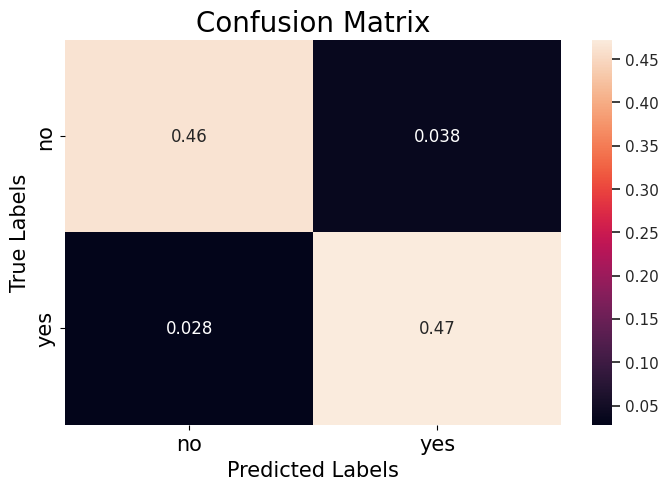

In [19]:
matrix = confusion_matrix(y_test, predictions_rnn, normalize='all')
plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["no", "yes"], size=15)
ax.yaxis.set_ticklabels(["no", "yes"], size=15)

# **CNN MODEL**

In [20]:
embedding_dim = 128
input_length = 300
dropout_rate = 0.5
filters = 64
kernel_size = 5
pool_size = 4
lstm_units = 128
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, embedding_dim, input_length=input_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=pool_size),
    tf.keras.layers.LSTM(lstm_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          2560000   
                                                                 
 dropout_1 (Dropout)         (None, 300, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
loss_function = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
num_epochs = 3
validation_split = 0.3
batch_size = 100
model_cnn.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
history_cnn = model_cnn.fit(X_train, y_train, epochs=num_epochs, validation_split=validation_split, batch_size=batch_size, shuffle=True, callbacks=[early_stop])

Epoch 1/3
3920/3920 [==============================] - 177s 44ms/step - loss: 0.2192 - accuracy: 0.8955 - val_loss: 0.1241 - val_accuracy: 0.9534
Epoch 2/3
3920/3920 [==============================] - 44s 11ms/step - loss: 0.1213 - accuracy: 0.9539 - val_loss: 0.1081 - val_accuracy: 0.9592
Epoch 3/3
3920/3920 [==============================] - 39s 10ms/step - loss: 0.1007 - accuracy: 0.9623 - val_loss: 0.1262 - val_accuracy: 0.9547


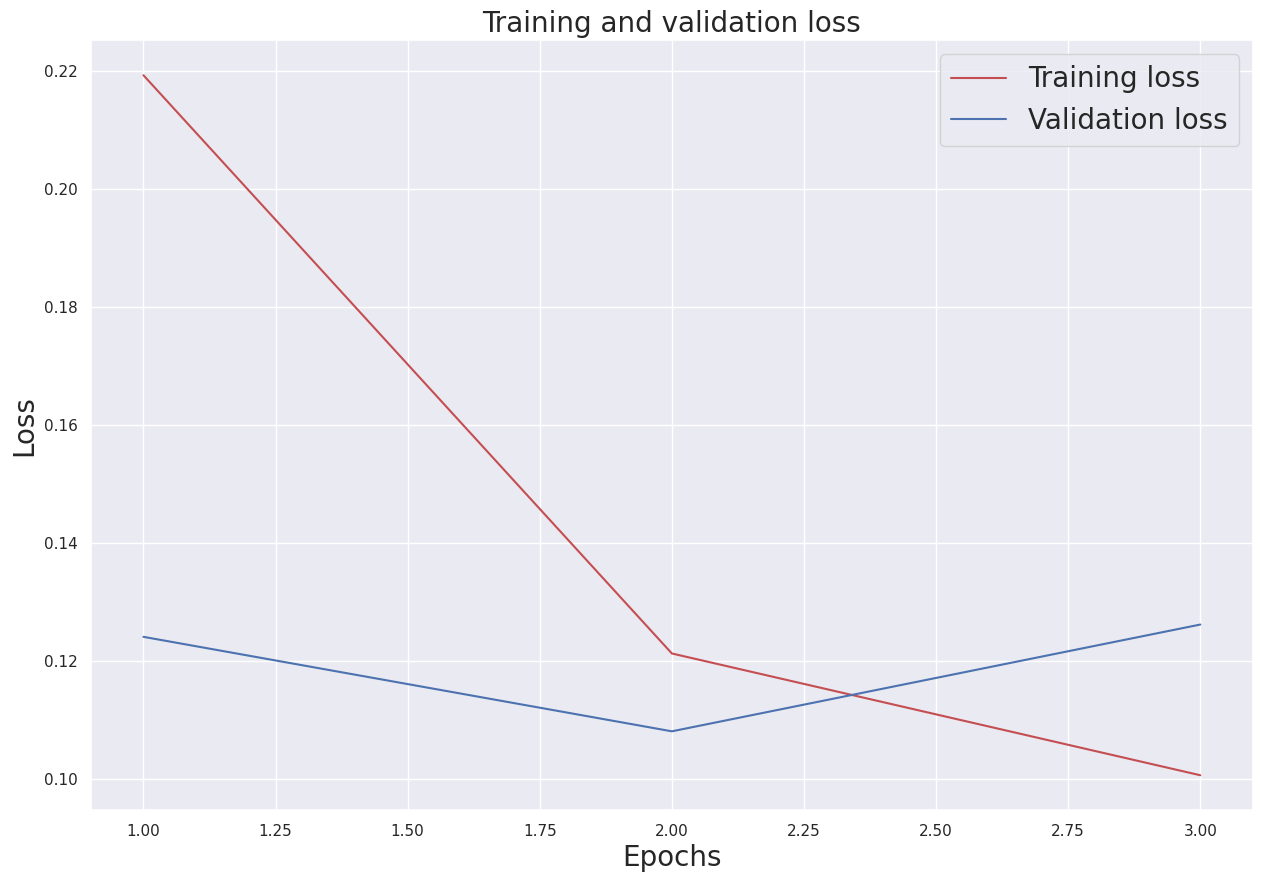

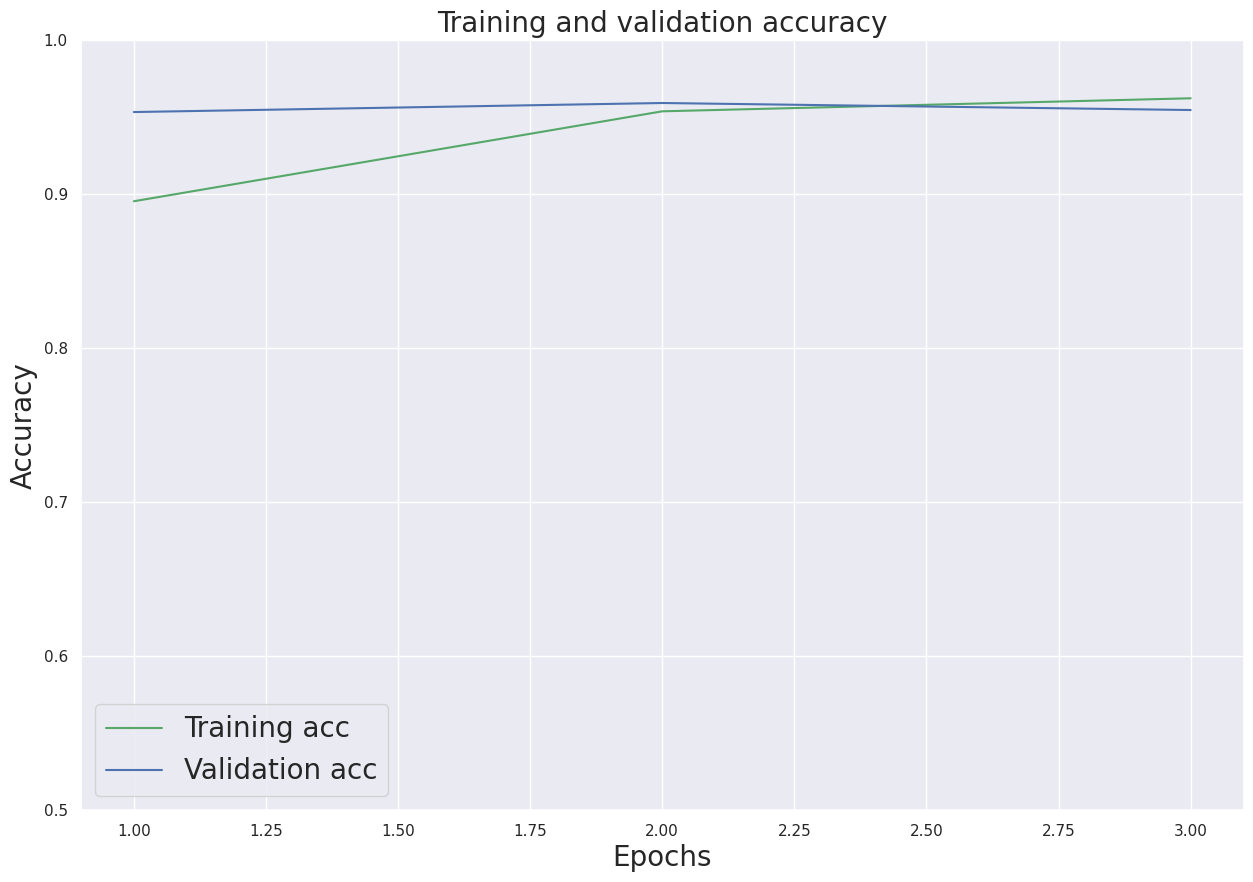

In [23]:
history_cnn_dict = history_cnn.history
acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']
epochs_cnn = range(1, num_epochs + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs_cnn, acc_cnn, 'g', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()


# Model Evaluation

In [24]:
model_cnn.evaluate(X_test, y_test)

1188/1188 [==============================] - 5s 3ms/step - loss: 0.1351 - accuracy: 0.9508


[0.13508066534996033, 0.9507894515991211]

In [25]:
pred_cnn = model_cnn.predict(X_test)
predictions_cnn = []

for i in pred_cnn:
    if i >= 0.5:
        predictions_cnn.append(1)
    else:
        predictions_cnn.append(0)
accuracy = accuracy_score(y_test, predictions_cnn)
precision = precision_score(y_test, predictions_cnn)
recall = recall_score(y_test, predictions_cnn)
print('Accuracy on testing set:', accuracy)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)

1188/1188 [==============================] - 3s 2ms/step
Accuracy on testing set: 0.9507894736842105
Precision on testing set: 0.9304452708814956
Recall on testing set: 0.974421052631579


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

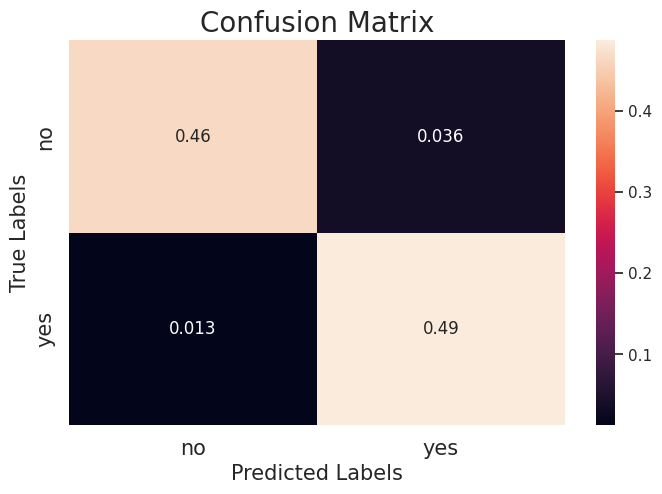

In [26]:
matrix = confusion_matrix(y_test, predictions_cnn, normalize='all')
plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["no", "yes"], size=15)
ax.yaxis.set_ticklabels(["no", "yes"], size=15)

# **Support Vector Machines**

In [27]:
svc_texts = list(train_data['text'])
svc_labels = list(train_data['class'])

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)

In [29]:
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
svc_classifier = LinearSVC(max_iter=5000)
Xs = vectorizer.fit_transform(svc_texts)
print(datetime.now() - t1)
print(Xs.shape)
score = cross_val_score(svc_classifier, Xs, svc_labels, cv=2, n_jobs=-1)
print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))
svc_classifier.fit(Xs, np.array(svc_labels))

0:02:26.826411
(560000, 1563653)
0:02:44.975093
[0.94867857 0.95306786]
0.9508732142857144


LinearSVC(max_iter=5000)

In [30]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, np.array(svc_labels), test_size=0.4)

In [31]:
svc_classifier.fit(Xs_train, ys_train)
svc_pred = svc_classifier.predict(Xs_test)

In [32]:
print("Report for Support Vector Machine:")
print(classification_report(ys_test, svc_pred))

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    111946
           1       0.96      0.95      0.95    112054

    accuracy                           0.95    224000
   macro avg       0.95      0.95      0.95    224000
weighted avg       0.95      0.95      0.95    224000



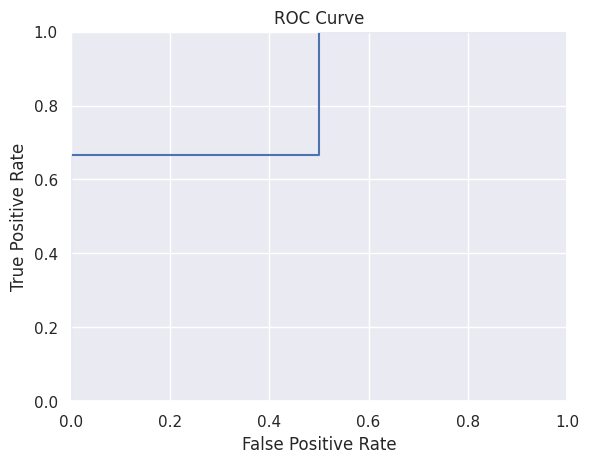

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
ys_test = [0, 1, 1, 0, 1]
svc_pred = [0.2, 0.7, 0.4, 0.6, 0.9]
fpr, tpr, thresholds = roc_curve(ys_test, svc_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

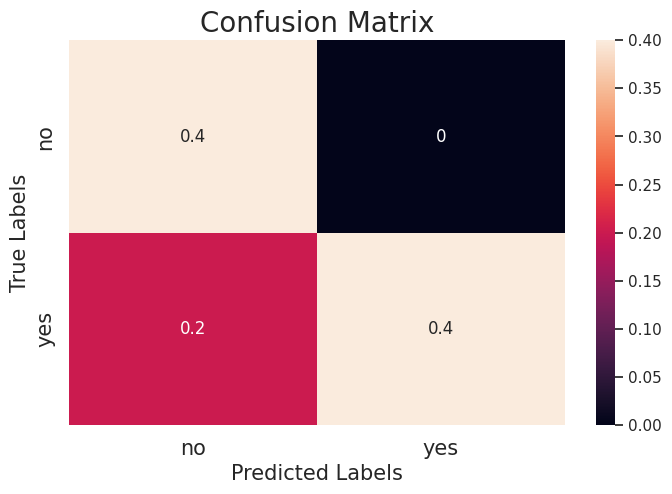

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
ys_test = [0, 1, 1, 0, 1]
svc_pred = [0, 1, 0, 0, 1]
matrix = confusion_matrix(ys_test, svc_pred, normalize='all')
plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["no", "yes"], size=15)
ax.yaxis.set_ticklabels(["no", "yes"], size=15)
plt.show()

# Applying the RNN Model on the new dataset.


In [36]:
sample = pd.read_csv('/content/yelp.csv')

In [37]:
sample.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have already preprocessed and prepared your data
sample_text_list = list(sample["text"])
labels = np.array(sample["stars"])

# Tokenize and convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_text_list)
sequences = tokenizer.texts_to_sequences(sample_text_list)

# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Load or define your RNN model
rnn_model = tf.keras.models.load_model('/content/drive/MyDrive/rnn_model.h5')

# Predict on new data
predictions = rnn_model.predict(padded_sequences)
y_output = [1 if pred > 0.5 else 0 for pred in predictions]
yp = ["Positive" if a == 1 else "Negative" for a in y_output]

# Prepare final output DataFrame
user_id = list(sample["user_id"])
business_id = list(sample["business_id"])
star = list(sample["stars"])
Predicted_reviews = pd.DataFrame({
    "user_id": user_id,
    "business_id": business_id,
    "Stars": star,
    "Review": sample_text_list,
    "Polarity": yp
})


313/313 [==============================] - 14s 42ms/step


In [52]:
Predicted_reviews["Polarity"]

0       Positive
1       Negative
2       Positive
3       Negative
4       Negative
          ...   
9995    Positive
9996    Negative
9997    Negative
9998    Negative
9999    Negative
Name: Polarity, Length: 10000, dtype: object

In [53]:
Predicted_reviews.to_csv('/content/drive/MyDrive/rnn_model_predictions.csv')